In [1]:
import yt
from matplotlib import rc_context
from matplotlib.animation import FuncAnimation

In [8]:
unit_base={"length_unit": (1.0,"pc"), "time_unit": (1.0,"s*pc/km"), "mass_unit": (2.38858753789e-24,"g/cm**3*pc**3")}
# ts = yt.load("kh_custom.out1.*.athdf", units_override=unit_base)

In [17]:
# Create a sample SlicePlot (this indirectly creates ImagePlot objects)
ts = yt.load('kh-shear.out2.*.athdf')

storage = {}

for sto, ds in ts.piter(storage=storage):
    slc = ds.slice('z', 0)
    frb = yt.FixedResolutionBuffer(
        slc,
        (
            ds.domain_left_edge[0],
            ds.domain_right_edge[0],
            ds.domain_left_edge[1],
            ds.domain_right_edge[1],
        ),
        (800, 800),
    )  # Resolution

    # Store the preloaded buffer
    sto.result = frb
    sto.result_id = str(ds)

    # Find min/max values
    # field_data = frb[field].d
    # val_min = min(val_min, field_data.min())
    # val_max = max(val_max, field_data.max())

    # Check for NaN or Inf in data
    # if np.isnan(field_data).any() or np.isinf(field_data).any():
    #     print(f"Invalid data (NaN or Inf) found in {ds}")
    #     quit(2)

print(storage)


# List all attributes and methods for the ImagePlot object
# print(dir(plot.plots[("gas", "density")]))

yt : [WARNING  ] 2024-09-14 22:37:47,596 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2024-09-14 22:37:47,597 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2024-09-14 22:37:47,597 Assuming 1.0 = 1.0 g


yt : [WARNING  ] 2024-09-14 22:37:47,598 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2024-09-14 22:37:47,623 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-09-14 22:37:47,623 Parameters: domain_dimensions         = [256 256   1]
yt : [INFO     ] 2024-09-14 22:37:47,623 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2024-09-14 22:37:47,623 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2024-09-14 22:37:47,624 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2024-09-14 22:37:47,627 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2024-09-14 22:37:47,628 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2024-09-14 22:37:47,628 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2024-09-14 22:37:47,628 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2024-09-14 22:37:47,646 Parameters: current_time              = 0.10027051
yt : [INFO     ] 2024-09-14 22:37:47,646 Parameters: domain_dimensions         = [256 256   1]
yt : [INFO     ] 2024-09-14 22:37:47,647 Param

{'kh-shear.out2.00000': <yt.visualization.fixed_resolution.FixedResolutionBuffer object at 0x11e4610c0>, 'kh-shear.out2.00001': <yt.visualization.fixed_resolution.FixedResolutionBuffer object at 0x128b52380>, 'kh-shear.out2.00002': <yt.visualization.fixed_resolution.FixedResolutionBuffer object at 0x11ef6afb0>, 'kh-shear.out2.00003': <yt.visualization.fixed_resolution.FixedResolutionBuffer object at 0x128cfb490>, 'kh-shear.out2.00004': <yt.visualization.fixed_resolution.FixedResolutionBuffer object at 0x128d58c40>, 'kh-shear.out2.00005': <yt.visualization.fixed_resolution.FixedResolutionBuffer object at 0x128d591e0>, 'kh-shear.out2.00006': <yt.visualization.fixed_resolution.FixedResolutionBuffer object at 0x128d5a1a0>, 'kh-shear.out2.00007': <yt.visualization.fixed_resolution.FixedResolutionBuffer object at 0x128d5add0>, 'kh-shear.out2.00008': <yt.visualization.fixed_resolution.FixedResolutionBuffer object at 0x128d5b820>, 'kh-shear.out2.00009': <yt.visualization.fixed_resolution.Fixed

In [15]:
ds = yt.load("kh-shear.out2.00050.athdf", units_override=unit_base)

yt : [WARNING  ] 2024-09-09 17:13:09,771 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2024-09-09 17:13:09,771 Overriding length_unit: 1.0 pc.
yt : [INFO     ] 2024-09-09 17:13:09,771 Overriding time_unit: 1.0 pc*s/km.
yt : [INFO     ] 2024-09-09 17:13:09,772 Overriding mass_unit: 2.38858753789e-24 g*pc**3/cm**3.
yt : [WARNING  ] 2024-09-09 17:13:09,773 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2024-09-09 17:13:09,800 Parameters: current_time              = 5.0
yt : [INFO     ] 2024-09-09 17:13:09,800 Parameters: domain_dimensions         = [256 256   1]
yt : [INFO     ] 2024-09-09 17:13:09,801 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2024-09-09 17:13:09,801 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2024-09-09 17:13:09,801 Parameters: cosmological_simulation   = 0


In [1]:
import numpy as np
import matplotlib.pyplot as plt



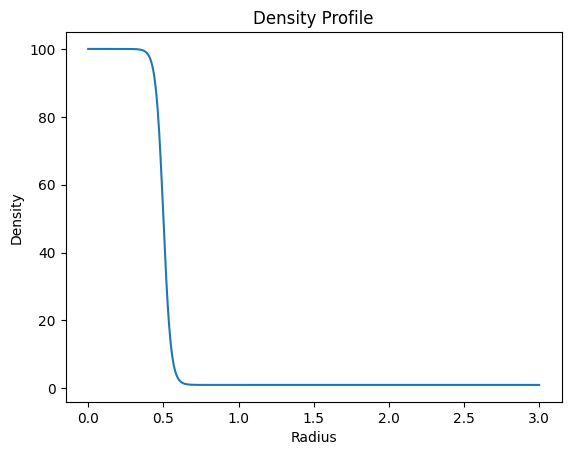

np.float64(1.0)

In [13]:
rho_0 = 1
density_contrast = 100
smoothing_thickness = 0.05
r = np.linspace(0, 3, 1000)
radius = 0.5

def density(r):
    return rho_0* ((density_contrast/2) + 0.5 + (density_contrast-1.0) * 0.5 * -np.tanh((r-radius)/smoothing_thickness) )

plt.title("Density Profile")
plt.xlabel("Radius")
plt.ylabel("Density")
plt.plot(r, density(r))
plt.show() 
density(3)

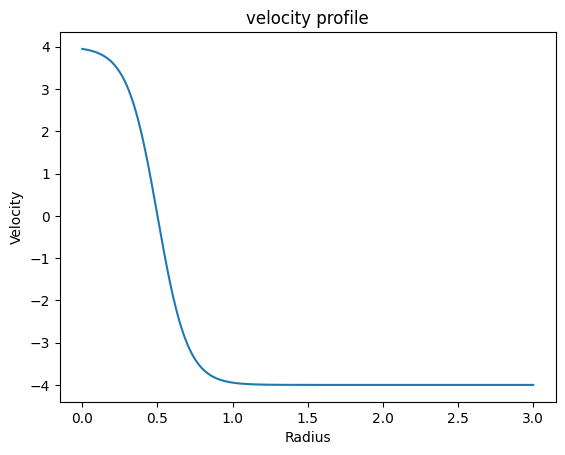

In [15]:
vel_shear = 4
smoothing_thickness_vel = 0.2

def velocity(r):
    return vel_shear * -1 * (np.tanh((r-radius)/smoothing_thickness_vel) )


plt.title("velocity profile")
plt.xlabel("Radius")
plt.ylabel("Velocity")
plt.plot(r, velocity(r))